# OBJECTIVE 2

Build a SURROGATE MODEL using GENERATIVE AI - Use a generative AI method to train a wildfires generative model.


In [1]:
# import the necessary libraries and the VAE.py and tools.py files,
# which provide additional functionality and implementations
import numpy as np
import VAE
import tools
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Step 1

Use the model data for training (Ferguson_fire_train) and test the model using the model data for testing (Ferguson_fire_test).

In [3]:
# read data and reshape them to the required shape for model
train_path = 'drive/My Drive/Ferguson_fire_train.npy'
train = np.load(train_path)
print(f"Before reshaping: {np.shape(train)}")
train_r = tools.reshape_2d(train)
print(f"After reshaping: {np.shape(train_r)}")

test_path = 'drive/My Drive/Ferguson_fire_test.npy'
test = np.load(test_path)
print(f"Before reshaping: {np.shape(test)}")
test_r = tools.reshape_2d(test)
print(f"After reshaping: {np.shape(test_r)}")

Before reshaping: (12500, 256, 256)
After reshaping: (12500, 65536)
Before reshaping: (5000, 256, 256)
After reshaping: (5000, 65536)


Our dataset is made up of 125 groups, each containing 100 sequential images of wildfires over time. We modify this dataset by removing some images at the beginning of each group for test data and some images at the end of each group  for the train data respectively, so that train_y (test_y) is just the next time step image of train_x (test_y) for each corresponding position.

In [4]:
# data preprocessing
train_x = tools.select_samples(train_r, start=99, step=100)
train_y = tools.select_samples(train_r,start=0, step=100)
print(f'After removing discontinuous samples: {train_x.shape}')

test_x = tools.select_samples(test_r, start=99, step=100)
test_y = tools.select_samples(test_r, start=0,step=100)
print(f'After removing discontinuous samples: {test_x.shape}')

After removing discontinuous samples: (12375, 65536)
After removing discontinuous samples: (4950, 65536)


In [5]:
# build and train the model
vae_model = VAE.VAE(latent_dim=128, input_dim=256*256*1, learning_rate=0.0001, reconstruction_weight=1.0, kl_weight=1.0)
vae_model.train(train_x, train_y, 256, 30, test_x, test_y)

Epoch 1/30
49/49 [==============================] - 11s 58ms/step - loss: 22192.9590 - val_loss: 8245.8516
Epoch 2/30
49/49 [==============================] - 1s 23ms/step - loss: 4750.3701 - val_loss: 3344.6758
Epoch 3/30
49/49 [==============================] - 1s 25ms/step - loss: 2582.4939 - val_loss: 2285.0962
Epoch 4/30
49/49 [==============================] - 1s 25ms/step - loss: 1884.8069 - val_loss: 1924.9688
Epoch 5/30
49/49 [==============================] - 1s 24ms/step - loss: 1681.6350 - val_loss: 1803.5273
Epoch 6/30
49/49 [==============================] - 1s 25ms/step - loss: 1562.8931 - val_loss: 1727.9785
Epoch 7/30
49/49 [==============================] - 1s 24ms/step - loss: 1483.0833 - val_loss: 1671.4613
Epoch 8/30
49/49 [==============================] - 1s 24ms/step - loss: 1422.4392 - val_loss: 1637.1805
Epoch 9/30
49/49 [==============================] - 1s 26ms/step - loss: 1370.0098 - val_loss: 1612.8054
Epoch 10/30
49/49 [==============================] - 

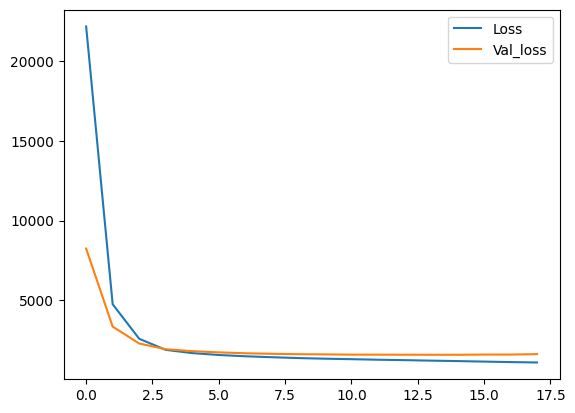

In [6]:
# plot the loss
vae_model.plot_loss()

In [7]:
# model prediction and calculate the MSE
test_x_pred = vae_model.vae.predict(test_x)
mse_structured = mean_squared_error(test_y, test_x_pred)
print(f'MSE: {mse_structured}') 

155/155 [==============================] - 1s 3ms/step
MSE: 0.00672190822660923


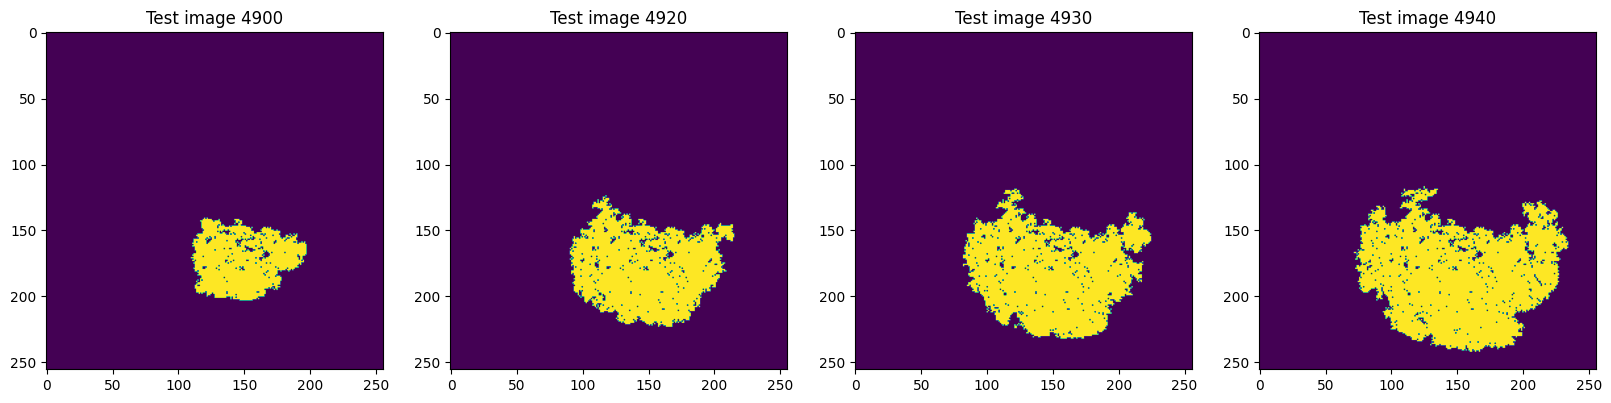

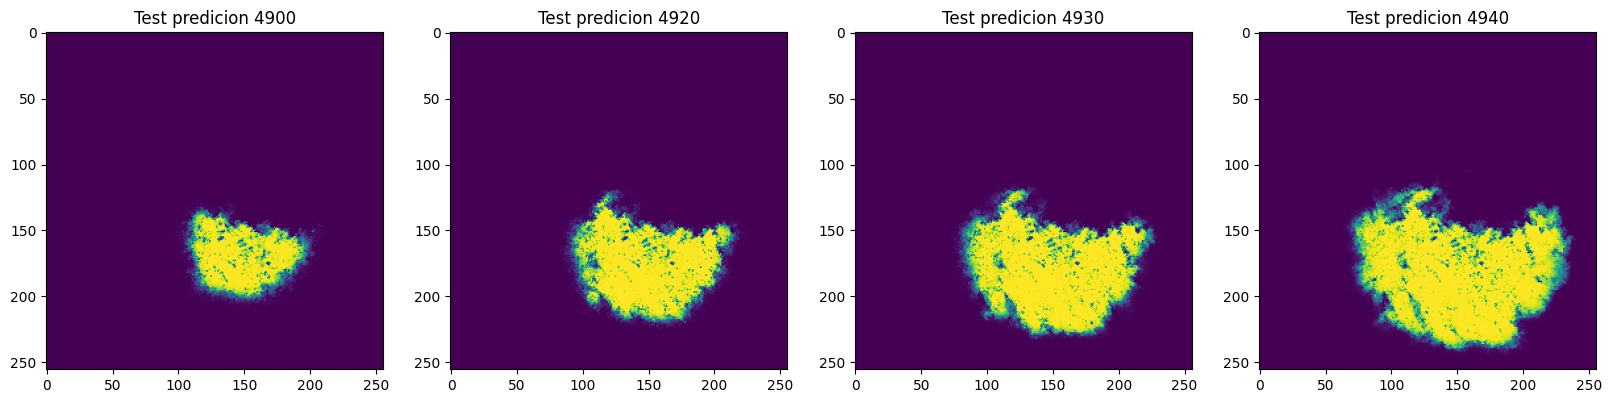

In [8]:
# plot and compare the predicted data and target  
ts = [4900, 4920, 4930, 4940]
tools.plot_data(test_y.reshape(-1, 256, 256), ts, [f'Test image {i}' for i in ts])
tools.plot_data(test_x_pred.reshape(-1, 256, 256), ts, [f'Test predicion {i}' for i in ts])

## Step 2

###Use the wildfire generative model to make a forecast.

We feed background data into the encoder model of our trained VAE model to map it into the latent space, allowing us to obtain representations of images. Then, utilizing the decoder model of our trained VAE model, we generate a forecast based on these latent space representations.

In [9]:
# read the data
obs_path = 'drive/My Drive/Ferguson_fire_obs.npy'
obs = np.load(obs_path)
print(obs.shape)

bg_path = 'drive/My Drive/Ferguson_fire_background.npy'
bg = np.load(bg_path)
print(bg.shape)

(5, 256, 256)
(5, 256, 256)


In [10]:
# predict wildfire behavior next timestep, and after 10 timesteps 
# since we find there are 10 timesteps between the imaged of background and observation data.
bg_x = tools.reshape_2d(bg[:-1])
bg_pred1 = vae_model.vae.predict(bg_x)
bg_pred10 = tools.pred_n_steps(vae_model.vae, bg_x, 10)


1/1 [==============================] - 0s 21ms/step


## Step 3
Compare your forecasted results with satellite data (Ferguson_fire_obs) and compute the MSE between your forecast and the satellite data. 


In [11]:
print(mean_squared_error(bg_pred10, obs[1:].reshape(-1,256*256)))
# print(mean_squared_error(bg_pred1, obs[1:].reshape(-1,256*256)))

0.08121579463784923


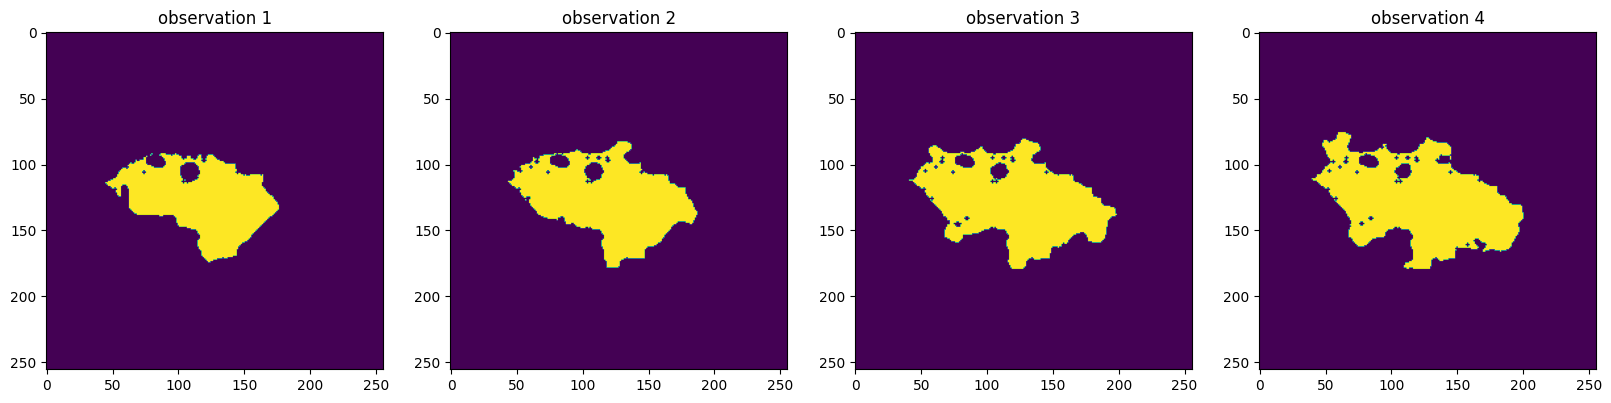

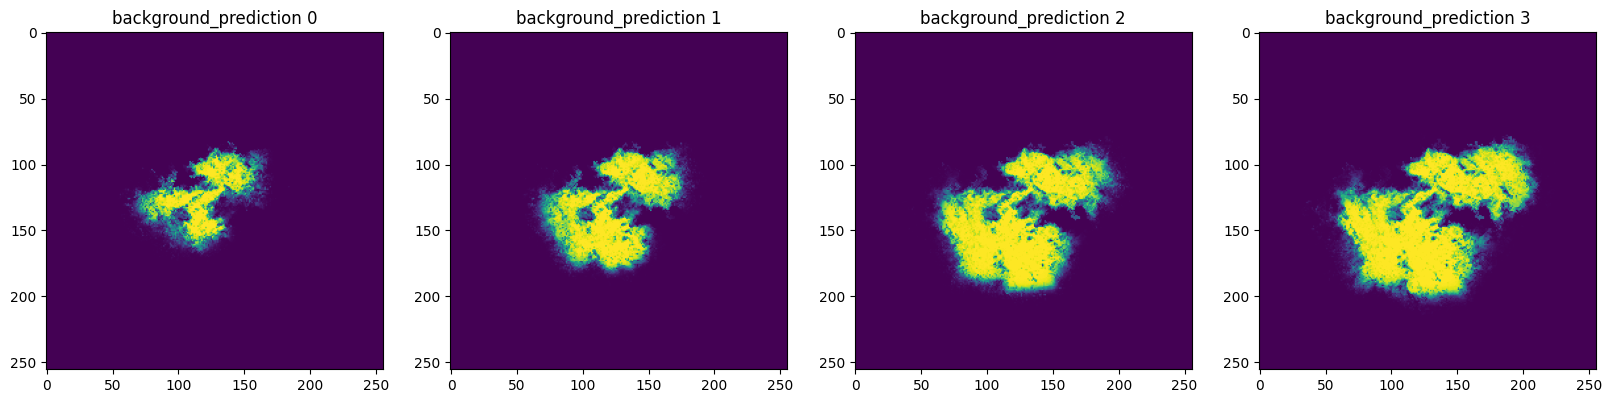

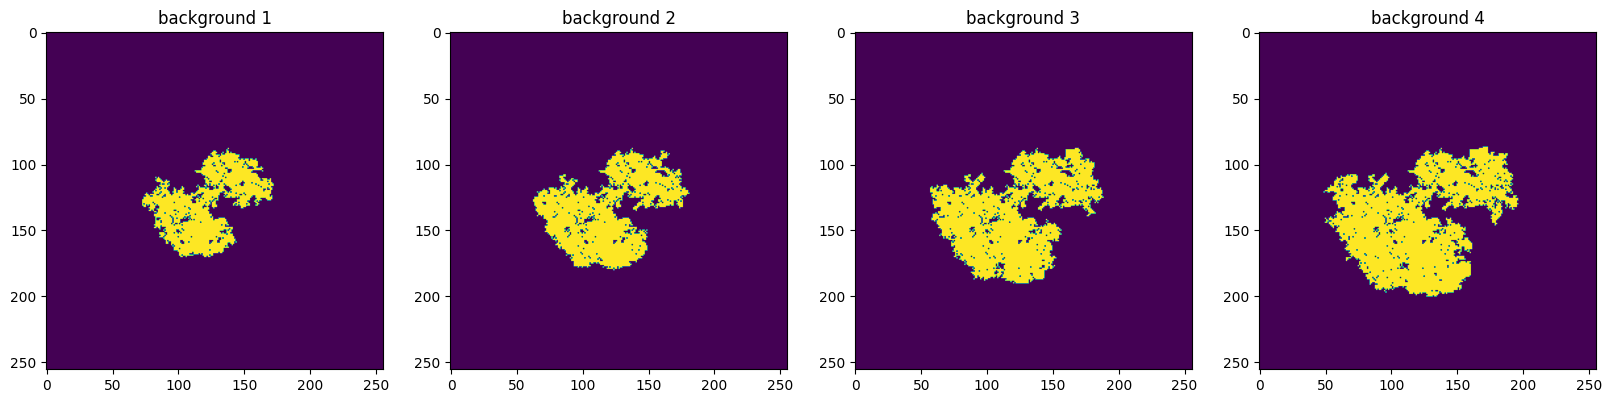

In [12]:
# plot and compare the predicted data and target
ts = [0,1,2,3,4]
tools.plot_data(obs, ts[1:],  [f'observation {i}' for i in ts[1:]])
tools.plot_data(bg_pred10.reshape(-1,256,256), ts[:-1],  [f'background_prediction {i}' for i in ts[:-1]])
tools.plot_data(bg.reshape(-1,256,256), ts[1:],  [f'background {i}' for i in ts[1:]])

In [13]:
# user can modify this path to save the models' output
path = 'drive/MyDrive/'
np.save(path+'vae_results.npy',bg_pred10)

In [14]:
# save the model
path = 'drive/MyDrive/vae.h5'
vae_model.vae.save(path)